In [29]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from typing import Literal

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from src.data import read_dataset, normalize
from train_model import get_model, train_model, get_criterion
from src.validation import evaluate_denoising_quality

USE_RAW_OUTPUT: bool = False
BATCH_SIZE: int = 32
VAL_SPLIT: float = 0.2
DEVICE = 'mps'
EPOCHS: int = 300
MODEL_TYPE: str = 'zinb'
LR: float = 1e-3
ENCODER_SIZES: list[int] = [128]  # Hidden layer sizes for encoder, [size_layer1, size_layer2, ...]
DECODER_SIZES: list[int] = [128]  # Hidden layer sizes for decoder, [size_layer1, size_layer2, ...]
BOTTLNECK_SIZE: int = 64  # Size of bottleneck layer
DROPOUT_RATE: float = 0.1  # Dropout rate for encoder and decoder

def set_seed(seed: int = 0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def get_data():
    df_train = pd.read_csv("data/sim_scdata_2_groups_2000.csv", index_col=0)
    groups = pd.Categorical(df_train["cell_groups_1_2000"]).codes
    df_train = df_train.drop(columns=["cell_groups_1_2000"])
    X_train = df_train.values.astype(np.float64)  # Changed from int64 to float64

    df_test = pd.read_csv("data/sim_scdata_2_groups_ndo_2000.csv", index_col=0)
    df_test = df_test.drop(columns=["cell_group_2_2000"])
    X_test = df_test.values.astype(np.float64)
    
    return X_train, X_test, groups


def get_loaders(verbose: bool = False):
    X, _, groups = get_data()
    if verbose:
        print(X.shape)

    adata = sc.AnnData(X.T)
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata

    adata = read_dataset(adata=adata, transpose=True, test_split=True, check_counts=False)
    adata = normalize(adata=adata, size_factors=True, logtrans_input=True, normalize_input=True)

    X = torch.tensor(adata.X, dtype=torch.float32)
    if verbose:
        print(X.shape)

    size_factors = torch.tensor(adata.obs["size_factors"].values, dtype=torch.float32).unsqueeze(1)
    output = torch.tensor(adata.raw.X if USE_RAW_OUTPUT else adata.X, dtype=torch.float32)

    dataset = TensorDataset(X, size_factors, output)
    train_size = int((1 - VAL_SPLIT) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    if verbose:
        print(f"Train size: {train_size}, Val size: {val_size}")

    input_shape = X.shape[1]
    return train_loader, val_loader, groups, input_shape, size_factors


In [38]:
set_seed(0)

train_loader, val_loader, groups, input_dim, size_factors = get_loaders(verbose=True)
model = get_model(MODEL_TYPE, input_dim, ENCODER_SIZES, BOTTLNECK_SIZE, DECODER_SIZES, DROPOUT_RATE)
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=10, verbose=True
)
criterion = get_criterion(MODEL_TYPE)

best_val_loss, train_losses, val_losses = train_model(
    model=model,
    epochs=EPOCHS,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    device=DEVICE,
)

clear_output()

/Users/marcus/Documents/Workspace/RNA-seq-denoising/src/validation.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  # 4. Signal-to-Noise Ratio


mse: 1770429.5872956587
rmse: 1330.5749085623322
mse_between_original_and_noisy: 38229.67263
mse_improvement: -4531.0351763419185
mean_row_correlation: -0.18943505125349047
mean_column_correlation: nan
original_snr: 13.416763158435124
denoised_snr: -3.240017639698944
snr_improvement: -16.65678079813407
silhouette_original: 0.05549835388250852
silhouette_noisy: 0.027049785138397314
silhouette_denoised: 8.053032797761261e-05
silhouette_improvement_vs_noisy: -0.0269692548104197
silhouette_improvement_vs_original: -0.055417823554530905

Original data without noise: mean = 254.63855, std = 858.2180190539568
Original data with noise: mean = 305.15048, std = 863.9975790248312
Reconstructed data: mean = 456.025390625, std = 868.1539916992188
MSE between original and original with noise: 38229.67263


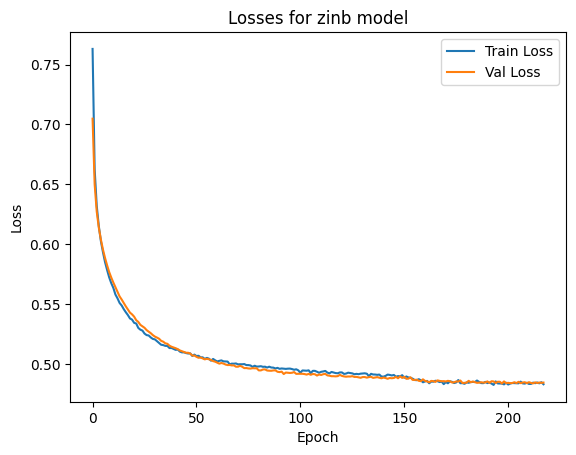

In [ ]:
X_train, X_test, groups = get_data()
reconstructed, disp, pi = model(torch.tensor(X_train, dtype=torch.float32).to(DEVICE), size_factors.to(DEVICE))
reconstructed = reconstructed.cpu().detach().numpy()

metrics = evaluate_denoising_quality(X_test, X_train, reconstructed, groups)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

print()
print(f"Original data without noise: mean = {X_train.mean()}, std = {X_train.std()}")
print(f"Original data with noise: mean = {X_test.mean()}, std = {X_test.std()}")
print(f"Reconstructed data: mean = {reconstructed.mean()}, std = {reconstructed.std()}")

# calculate mse between original and original with noise
mse_original = np.mean((X_train - X_test) ** 2)
print(f"MSE between original and original with noise: {mse_original}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Losses for {MODEL_TYPE} model")
plt.legend()
plt.show()

(2000, 200)


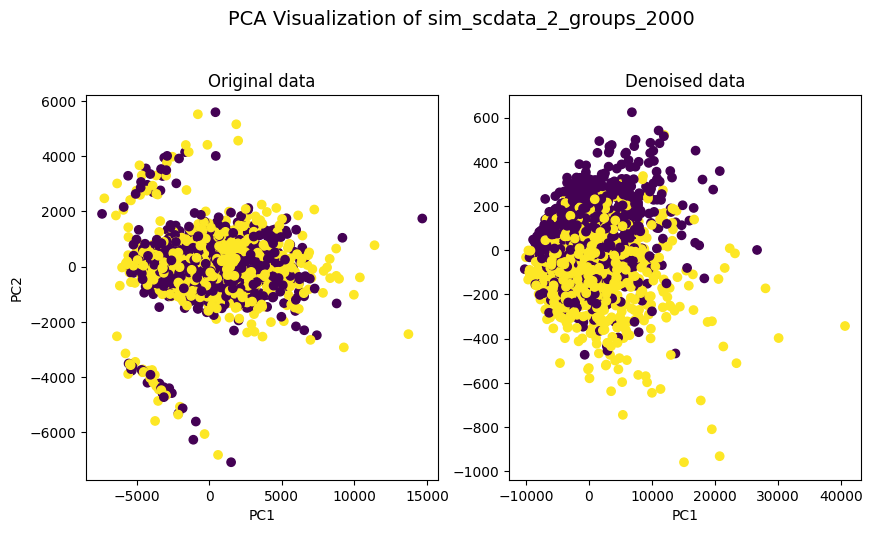

In [27]:
df = pd.read_csv("data/sim_scdata_2_groups_2000.csv", index_col=0)
groups = pd.Categorical(df["cell_groups_1_2000"]).codes
df = df.drop(columns=["cell_groups_1_2000"])
X = df.values.astype(np.float64)  # Changed from int64 to float64
print(X.shape)

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

mean, disp, pi = model(torch.tensor(X, dtype=torch.float32).to(DEVICE), size_factors.to(DEVICE))
mean = mean.detach().cpu().numpy()

pca = PCA(n_components=2)
pca.fit(mean)
X_denoised = pca.transform(mean)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle("PCA Visualization of sim_scdata_2_groups_2000", fontsize=14, y=1.05)
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=groups)
ax[0].set_title("Original data")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

ax[1].scatter(X_denoised[:, 0], X_denoised[:, 1], c=groups)
ax[1].set_title("Denoised data")
ax[1].set_xlabel("PC1")

plt.show()

In [ ]:
models = {}

n_runs_per_bottleneck = 3
bottlenecks = [8, 16, 32, 64]
seeds = [0, 3, 3, 0]
reconstruction_errors = {bottleneck: [] for bottleneck in bottlenecks}
metrics = {bottleneck: [] for bottleneck in bottlenecks}

for bottleneck, seed in zip(bottlenecks, seeds):
    set_seed(seed)
    for i in range(n_runs_per_bottleneck):
        train_loader, val_loader, groups, input_dim, size_factors = get_loaders()
        model = get_model(MODEL_TYPE, input_dim, ENCODER_SIZES, bottleneck, DECODER_SIZES, DROPOUT_RATE)
        model.to(DEVICE)

        optimizer = optim.Adam(model.parameters(), lr=LR)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=10, verbose=True
        )
        criterion = get_criterion(MODEL_TYPE)

        best_val_loss, train_losses, val_losses = train_model(
            model=model,
            epochs=EPOCHS,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            device=DEVICE,
        )

        # Calculate reconstruction error
        X_train, X_test, groups = get_data()
        mean, disp, pi = model(torch.tensor(X_train, dtype=torch.float32).to(DEVICE), size_factors.to(DEVICE))
        mean = mean.detach().cpu().numpy()
        reconstruction_errors[bottleneck].append(np.mean((X - mean) ** 2))
        metrics[bottleneck].append(evaluate_denoising_quality(X_test, X_train, mean, groups))

        if i == 0:
            models[bottleneck] = {
                "model": model,
                "train_losses": train_losses,
                "val_losses": val_losses,
            }

        clear_output()

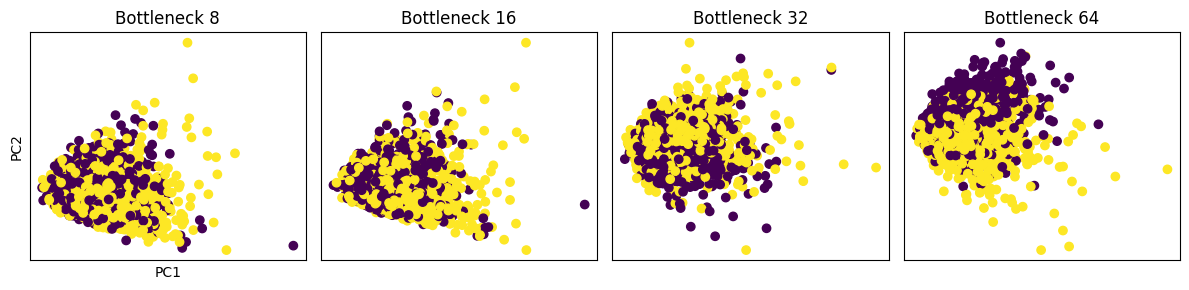

In [33]:
X_train, X_test, groups = get_data()

pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X)

use_orig_data: Literal[0, 1] = 0

fig, ax = plt.subplots(1, len(models.keys()) + use_orig_data, figsize=(3 * (len(models.keys()) + use_orig_data), 3))
# plt.suptitle("PCA Visualization of sim_scdata_2_groups_2000", fontsize=14, y=1.05)
if use_orig_data:
    ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=groups)
    ax[0].set_title("Original data")

for i, (bottleneck, model_dict) in enumerate(models.items()):
    X_train, X_test, groups = get_data()

    model = model_dict["model"]
    mean, disp, pi = model(torch.tensor(X_train, dtype=torch.float32).to(DEVICE), size_factors.to(DEVICE))
    mean = mean.detach().cpu().numpy()

    pca = PCA(n_components=2)
    pca.fit(mean)
    X_denoised = pca.transform(mean)

    ax[i + use_orig_data].scatter(X_denoised[:, 0], X_denoised[:, 1], c=groups)
    ax[i + use_orig_data].set_title(f"Bottleneck {bottleneck}")

# disable ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

plt.tight_layout()
plt.savefig(f"sim_scdata_2_groups_2000_bottleneck_sizes_{MODEL_TYPE}.pdf")
plt.show()

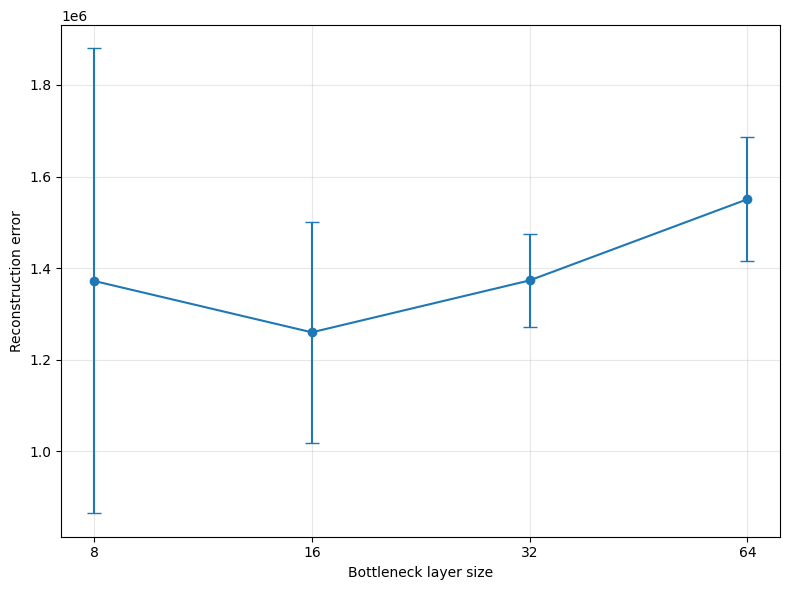

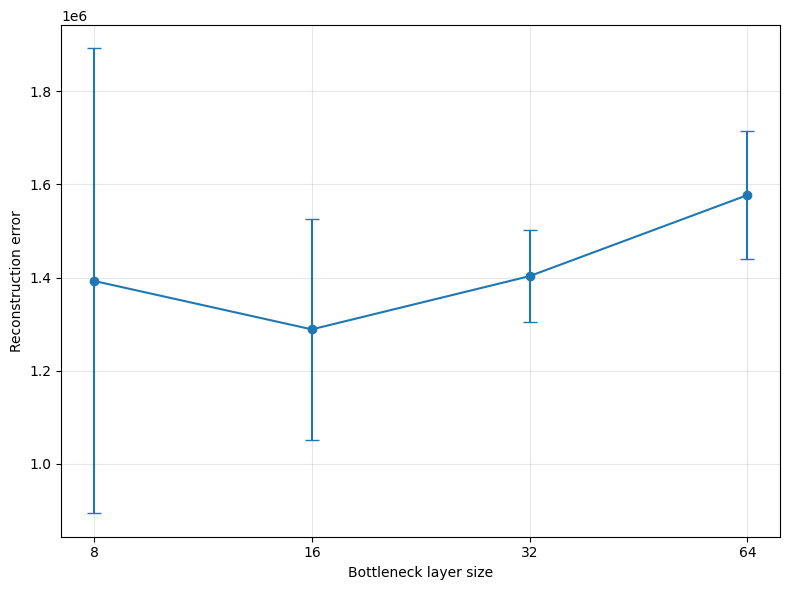

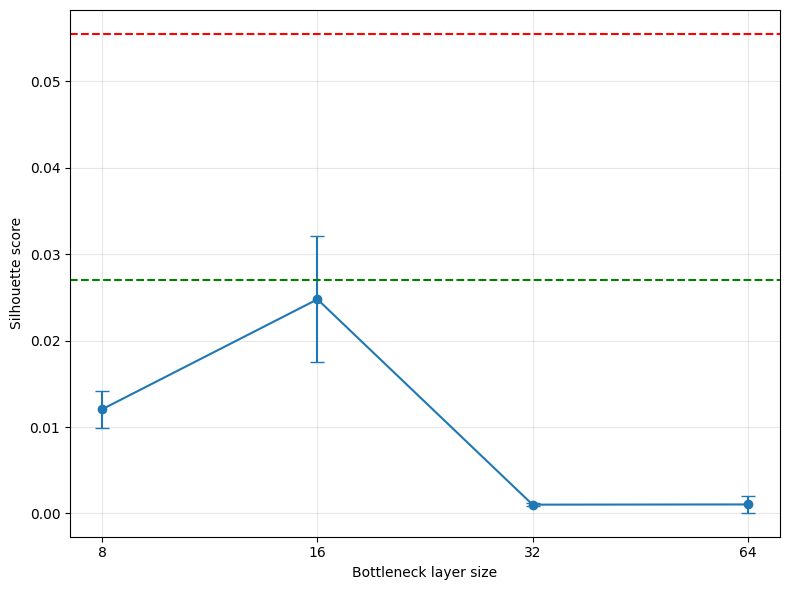

In [37]:
def plot_reconstruction_errors_old(results_dict):
    bottleneck_sizes = sorted(results_dict.keys())
    means = [np.mean(results_dict[size]) for size in bottleneck_sizes]
    stds = [np.std(results_dict[size]) for size in bottleneck_sizes]

    plt.figure(figsize=(8, 6))
    plt.errorbar(bottleneck_sizes, means, yerr=stds, 
                fmt='o-', capsize=5, color='#1f77b4', 
                markersize=6, linewidth=1.5)
    
    plt.xscale('log', base=2)
    plt.xlabel('Bottleneck layer size')
    plt.ylabel('Reconstruction error')
    plt.xticks(bottleneck_sizes, [str(x) for x in bottleneck_sizes])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"sim_scdata_2_groups_2000_mse_bottleneck_sizes_{MODEL_TYPE}.pdf")
    plt.show()

def plot_metrics(results_dict: dict[int, list[dict[str, float]]]):
    bottleneck_sizes = sorted(results_dict.keys())
    
    mses = {size: [metric['mse'] for metric in results_dict[size]] for size in bottleneck_sizes}
    mses_means = [np.mean(mses[size]) for size in bottleneck_sizes]
    mses_stds = [np.std(mses[size]) for size in bottleneck_sizes]
    plt.figure(figsize=(8, 6))
    plt.errorbar(bottleneck_sizes, mses_means, yerr=mses_stds, 
                fmt='o-', capsize=5, color='#1f77b4', 
                markersize=6, linewidth=1.5)
    
    plt.xscale('log', base=2)
    plt.xlabel('Bottleneck layer size')
    plt.ylabel('Reconstruction error')
    plt.xticks(bottleneck_sizes, [str(x) for x in bottleneck_sizes])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.savefig(f"sim_scdata_2_groups_2000_mse_bottleneck_sizes_{MODEL_TYPE}.pdf")
    plt.show()

    silhouettes = {size: [metric['silhouette_denoised'] for metric in results_dict[size]] for size in bottleneck_sizes}
    silhouettes_means = [np.mean(silhouettes[size]) for size in bottleneck_sizes]
    silhouettes_stds = [np.std(silhouettes[size]) for size in bottleneck_sizes]

    original_silhouette = results_dict[bottleneck_sizes[0]][0]['silhouette_original']
    noise_silhouette = results_dict[bottleneck_sizes[0]][0]['silhouette_noisy']

    plt.figure(figsize=(8, 6))
    plt.errorbar(bottleneck_sizes, silhouettes_means, yerr=silhouettes_stds, 
                fmt='o-', capsize=5, color='#1f77b4', 
                markersize=6, linewidth=1.5)
    plt.axhline(original_silhouette, color='r', linestyle='--', label='Original data')
    plt.axhline(noise_silhouette, color='g', linestyle='--', label='Noisy data')
    plt.xscale('log', base=2)
    plt.xlabel('Bottleneck layer size')
    plt.ylabel('Silhouette score')
    plt.xticks(bottleneck_sizes, [str(x) for x in bottleneck_sizes])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.savefig(f"sim_scdata_2_groups_2000_silhouette_bottleneck_sizes_{MODEL_TYPE}.pdf")
    plt.show()

plot_reconstruction_errors_old(reconstruction_errors)
plot_metrics(metrics)

In [ ]:
for i, (bottleneck, model_dict) in enumerate(models.items()):
    df = pd.read_csv("data/sim_scdata_2_groups_2000.csv", index_col=0)
    groups = pd.Categorical(df["cell_groups_1_2000"]).codes
    df = df.drop(columns=["cell_groups_1_2000"])
    X = df.values.astype(np.float64)  # Changed from int64 to float64

    model = model_dict["model"]
    mean, disp, pi = model(torch.tensor(X, dtype=torch.float32).to(DEVICE), size_factors.to(DEVICE))
    mean = mean.detach().cpu().numpy()

    denoised_df = pd.DataFrame(mean, index=df.index, columns=df.columns)

    # insert group column back
    denoised_df["cell_groups_1_2000"] = groups

    # order columns so that group column is first
    cols = denoised_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    denoised_df = denoised_df[cols]

    denoised_df.to_csv(f"denoised/sim_scdata_2_groups_2000_denoised_bottleneck_{bottleneck}_{MODEL_TYPE}.csv")

denoised_df.head()
